In [1]:
%matplotlib inline

import os
from dataclasses import dataclass

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xarray as xr
from neurolib.models.multimodel.builder.aln import (
    ALN_EXC_DEFAULT_PARAMS,
    ALN_INH_DEFAULT_PARAMS,
    ALNNode,
)
from neurolib.utils.stimulus import OrnsteinUhlenbeckProcess
from scipy.ndimage.filters import gaussian_filter

DPI = 75
CMAP = "plasma"
plt.rcParams["figure.figsize"] = (20, 9)
plt.style.use("default_light")

DATA = "data/fig4-aln_bifurcation"


def norm_ou_mu(da):
    da["ou_exc_mu"] = da["ou_exc_mu"] / 5.0
    da["ou_inh_mu"] = da["ou_inh_mu"] / 5.0
    return da

In [2]:
@dataclass
class Point:
    name: str
    ou_exc: float
    ou_inh: float
    marker: str
    size_mult: float = 1.0


def aln_ts(e, i, noise):
    DURATION = 10000
    SPIN_UP = 5000
    DT = 0.01
    params_update = {"a": 0.0, "b": 15.0, "tauA": 1000.0}

    aln = ALNNode(
        exc_params={**ALN_EXC_DEFAULT_PARAMS, **params_update},
        inh_params={**ALN_INH_DEFAULT_PARAMS, **params_update},
    )
    aln.index = 0
    aln.idx_state_var = 0
    aln.init_node()

    noise_exc = OrnsteinUhlenbeckProcess(
        mu=e,
        sigma=noise,
        tau=5,
        seed=42,
    ).as_array(DURATION + SPIN_UP, DT)
    noise_inh = OrnsteinUhlenbeckProcess(
        mu=i,
        sigma=noise,
        tau=5,
        seed=512,
    ).as_array(DURATION + SPIN_UP, DT)

    results = aln.run(
        duration=DURATION + SPIN_UP,
        dt=DT,
        noise_input=np.hstack([noise_exc, noise_inh]).T,
        backend="numba",
    )
    return results.isel({"time": slice(SPIN_UP, None)})

In [3]:
adex_maxE = xr.open_dataarray(os.path.join(DATA, "adex_maxE.nc")) * 1000
adex_ampdiff = xr.open_dataarray(os.path.join(DATA, "adex_amp_diff.nc")) * 1000
adex_domfr = xr.open_dataarray(os.path.join(DATA, "adex_domfr.nc")).isel({"time": 0})

adex_maxE = norm_ou_mu(adex_maxE)
adex_ampdiff = norm_ou_mu(adex_ampdiff)
adex_domfr = norm_ou_mu(adex_domfr)

/Users/nikola/.virtualenvs/sleepy/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: No contour levels were found within the data range.
/Users/nikola/.virtualenvs/sleepy/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: No contour levels were found within the data range.
/Users/nikola/.virtualenvs/sleepy/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: No contour levels were found within the data range.
/Users/nikola/.virtualenvs/sleepy/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: No contour levels were found within the data range.


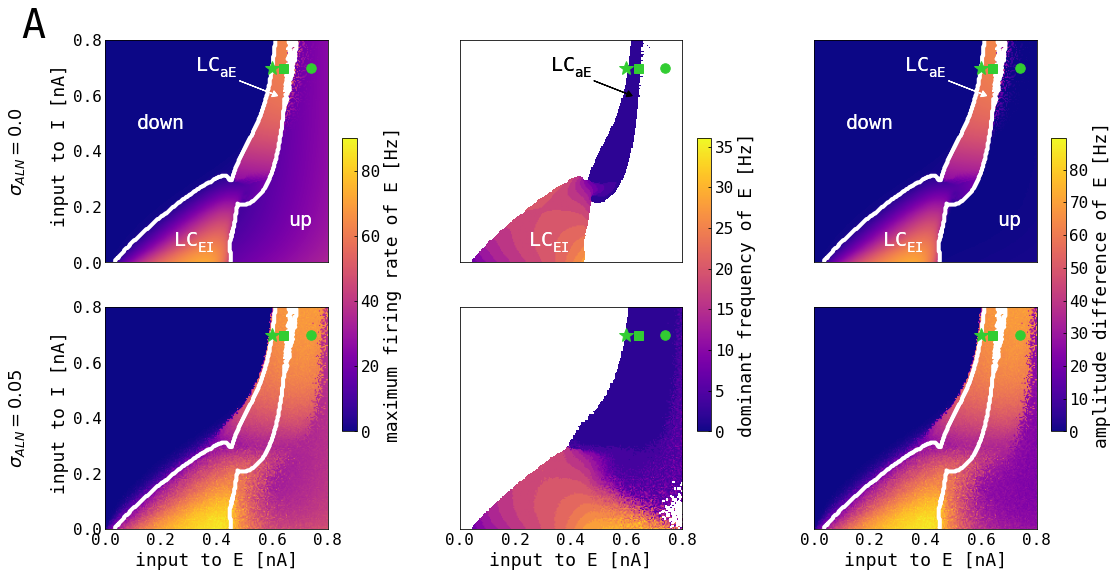

In [4]:
FR_THRESH = 0.5

lc = Point("LC", 3.2, 3.5, "s", 0.9)
left = Point("left", 3.0, 3.5, "*", 1.4)
right = Point("right", 3.7, 3.5, "o", 0.95)
mark_points = [lc, left, right]

fig, axs = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(18, 9))

cbar_labs = [
    "maximum firing rate of E [Hz]",
    "dominant frequency of E [Hz]",
    "amplitude difference of E [Hz]",
]
bbox_props = dict(boxstyle="square", facecolor="gray", alpha=0.8, edgecolor="none")


def annotate(ax, contour):
    ax.text(
        x=0.2,
        y=0.5,
        s="down",
        color="w",
        fontsize=20,
        ha="center",
        va="center",
    )
    ax.text(x=0.7, y=0.15, s="up", color="w", fontsize=20, ha="center", va="center")
    ax.text(
        x=0.32,
        y=0.07,
        s="$\mathregular{LC_{EI}}$",
        color="w",
        fontsize=20,
        ha="center",
        va="center",
    )
    ax.annotate(
        "$\mathregular{LC_{aE}}$",
        xy=(0.62, 0.6),
        xytext=(0.4, 0.7),
        color="w" if contour else "k",
        fontsize=20,
        ha="center",
        va="center",
        arrowprops=dict(
            fc="white" if contour else "k",
            ec="white" if contour else "k",
            width=0.1,
            headwidth=6.0,
            headlength=5.0,
        ),
    )


contour = [True, False, True]
for j, fld in enumerate(
    [adex_maxE, adex_domfr.where(adex_domfr > 0.0, np.nan), adex_ampdiff]
):
    for i, noise in enumerate(adex_maxE["ou_sigma"]):
        img = axs[i, j].imshow(
            fld.sel({"ou_sigma": noise}).values.T,
            cmap=CMAP,
            origin="lower",
            vmin=0.0,
            vmax=np.nanmax(fld.values),
            extent=[
                adex_maxE["ou_exc_mu"].min(),
                adex_maxE["ou_exc_mu"].max(),
                adex_maxE["ou_inh_mu"].min(),
                adex_maxE["ou_inh_mu"].max(),
            ],
            aspect=4 / 4,
        )
        annotate(axs[0, j], contour[j])
        for point in mark_points:
            axs[i, j].plot(
                point.ou_exc / 5.0,
                point.ou_inh / 5.0,
                marker=point.marker,
                markersize=10 * point.size_mult,
                color="limegreen",
            )
        if contour[j]:
            blurred = gaussian_filter(adex_domfr.sel({"ou_sigma": 0.0}).values, 0.0)
            blurred[blurred < FR_THRESH] = 0
            blurred[blurred >= FR_THRESH] = 1
            xi, yi = np.meshgrid(fld["ou_exc_mu"], fld["ou_inh_mu"])
            axs[i, j].contour(
                xi,
                yi,
                blurred.T,
                colors="white",
                linestyles="solid",
                levels=[0, 1.0001],
                linewidths=(4,),
                zorder=1,
            )
        noise_label = (
            f"$\sigma_{{ALN}}={noise.values}$"
            if noise.values == 0.0
            else f"$\sigma_{{ALN}}={noise.values}$"
        )
        axs[i, 0].set_ylabel(noise_label + "\n\n input to I [nA]")
        axs[-1, j].set_xlabel("input to E [nA]")
    cbar = fig.colorbar(img, shrink=0.6, ax=axs[:, j])
    cbar.set_label(cbar_labs[j])
plt.text(
    0.08,
    0.9,
    "A",
    ha="center",
    va="center",
    transform=fig.transFigure,
    fontsize=40,
)
# to PDF due transparency
plt.savefig(
    "../figs/aln_bifurcation.pdf", dpi=DPI, transparent=True, bbox_inches="tight"
)

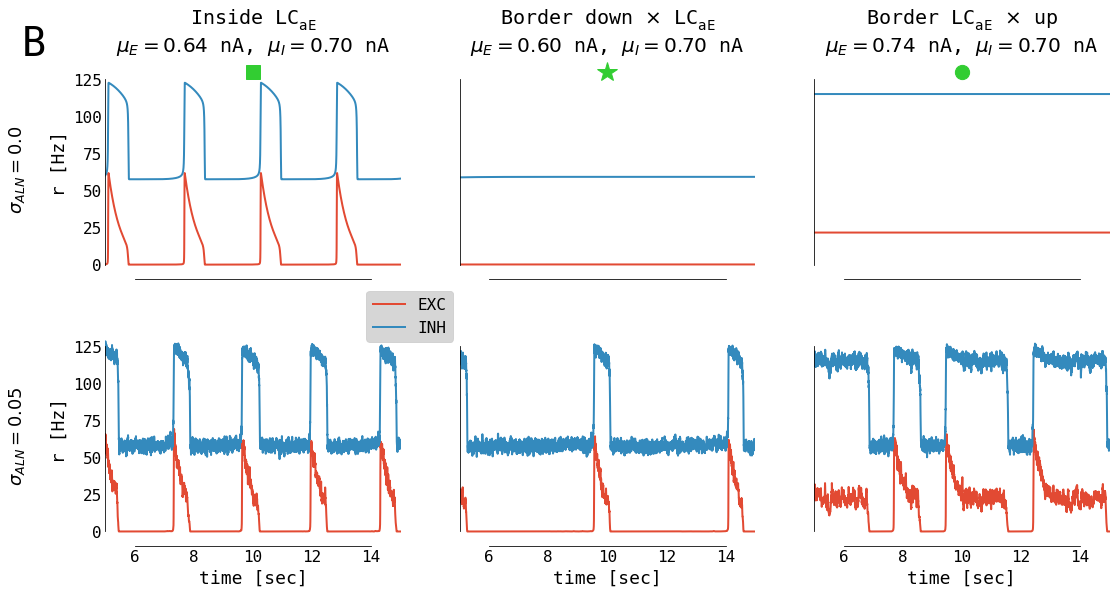

In [5]:
fig, axs = plt.subplots(ncols=3, nrows=2, sharey=True, sharex=True, figsize=(18, 9))
for ii, noise in enumerate([0.0, 0.05]):
    # inside
    ax = axs[ii, 0]
    aln_ = aln_ts(e=lc.ou_exc, i=lc.ou_inh, noise=noise)
    ax.plot(aln_.time, aln_["r_mean_EXC"] * 1000.0, color="C0", label="EXC")
    ax.plot(aln_.time, aln_["r_mean_INH"] * 1000.0, color="C1", label="INH")
    ax.set_ylim([-10, 140])
    ax.set_xlim([5, 15])
    ax.set_ylabel(f"$\sigma_{{ALN}}={noise}$ \n\n r [Hz]")
    if ii == 0:
        ax.set_title(
            "Inside $\mathregular{{LC_{{aE}}}}$"
            f"\n$\mu_{{E}}={lc.ou_exc / 5.0:.2f}$ nA, $\mu_{{I}}={lc.ou_inh / 5.0:.2f}$ nA"
        )
        ax.plot(
            10, 130, marker=lc.marker, color="limegreen", markersize=15 * lc.size_mult
        )
    if ii == 1:
        ax.set_xlabel("time [sec]")
    sns.despine(trim=True)

    # left border
    ax = axs[ii, 1]
    aln_ = aln_ts(e=left.ou_exc, i=left.ou_inh, noise=noise)  # bif 4.31 - 4.32
    ax.plot(aln_.time, aln_["r_mean_EXC"] * 1000.0, color="C0", label="EXC")
    ax.plot(aln_.time, aln_["r_mean_INH"] * 1000.0, color="C1", label="INH")
    if ii == 0:
        ax.set_title(
            r"Border down $\times$ $\mathregular{{LC_{{aE}}}}$"
            f"\n$\mu_{{E}}={left.ou_exc / 5.0:.2f}$ nA, $\mu_{{I}}={left.ou_inh / 5.0:.2f}$ nA"
        )
        ax.plot(
            10,
            130,
            marker=left.marker,
            color="limegreen",
            markersize=15 * left.size_mult,
        )
    if ii == 1:
        ax.set_xlabel("time [sec]")
    sns.despine(trim=True)

    # right border
    ax = axs[ii, 2]
    aln_ = aln_ts(e=right.ou_exc, i=right.ou_inh, noise=noise)  # bif
    (l1,) = ax.plot(aln_.time, aln_["r_mean_EXC"] * 1000.0, color="C0", label="EXC")
    (l2,) = ax.plot(aln_.time, aln_["r_mean_INH"] * 1000.0, color="C1", label="INH")
    if ii == 0:
        ax.set_title(
            r"Border $\mathregular{{LC_{{aE}}}}$ $\times$ up"
            f"\n$\mu_{{E}}={right.ou_exc / 5.0:.2f}$ nA, $\mu_{{I}}={right.ou_inh / 5.0:.2f}$ nA"
        )
        ax.plot(
            10,
            130,
            marker=right.marker,
            color="limegreen",
            markersize=15 * right.size_mult,
        )
    if ii == 1:
        ax.set_xlabel("time [sec]")
    sns.despine(trim=True)
fig.legend(
    (l1, l2),
    ("EXC", "INH"),
    loc="center",
    bbox_to_anchor=(0.36, 0.48),
    bbox_transform=fig.transFigure,
)
plt.text(
    0.07,
    0.9,
    "B",
    ha="center",
    va="center",
    transform=fig.transFigure,
    fontsize=40,
)
plt.savefig(
    "../figs/aln_timeseries.pdf", dpi=DPI, transparent=True, bbox_inches="tight"
)